XGBoost Regression Model for sales quantity forecasting

In [2]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

import xgboost as xgb
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Loading and Filtering

In [ ]:
path = '/data/SI_RETAIL.csv'

In [5]:
# Read from csv file

df_full = pd.read_csv(path)
print(df_full.shape)
df_full.head()

(60729, 9)


,DOC_ID,RETAILER_CODE,DATE,PRODUCT_BRAND,PACK_SIZE,PRODUCT_ID,SALES_QTY,UNIT_PRICE,SALES_VALUE
0,SI_097029,RET00210,01/01/2024,DOVE BODY WASH,500 ML,DOVE BODY WASH_500 ML,12,8.0,96
1,SI_097082,RET00210,01/01/2024,KELLOGS CORN FLAKES,500 G,KELLOGS CORN FLAKES_500 G,12,5.5,66
2,SI_097023,RET00210,01/01/2024,DASANI WATER,300 ML,DASANI WATER_300 ML,10,2.0,19
3,SI_097025,RET00210,01/01/2024,DASANI WATER,300 ML,DASANI WATER_300 ML,7,2.0,14
4,SI_097027,RET00210,01/01/2024,DASANI WATER,300 ML,DASANI WATER_300 ML,7,2.0,14


In [6]:
df_full.isna().sum()

DOC_ID           0
RETAILER_CODE    0
DATE             0
PRODUCT_BRAND    0
PACK_SIZE        0
PRODUCT_ID       0
SALES_QTY        0
UNIT_PRICE       0
SALES_VALUE      0
dtype: int64

In [7]:
df_full.duplicated().sum()

0

In [8]:
# Aggregate same-day records per PRODUCT_ID

# Convert DATE to datetime format
df_full['DATE'] = pd.to_datetime(df_full['DATE'], dayfirst=True)

# Group by DATE and PRODUCT_ID
aggregated_df = (
    df_full.groupby(['DATE', 'PRODUCT_ID'], as_index=False)
    .agg({
        'PRODUCT_BRAND': 'first',
        'PACK_SIZE': 'first',
        'UNIT_PRICE': 'first', 
        'SALES_QTY': 'sum',
        'SALES_VALUE': 'sum'
    })
)

print(aggregated_df.shape)
print("Min DATE:", aggregated_df["DATE"].min())
print("Max DATE:", aggregated_df["DATE"].max())
aggregated_df.head()



(10436, 7)
Min DATE: 2024-01-01 00:00:00
Max DATE: 2025-03-30 00:00:00


,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE
0,2024-01-01,DASANI WATER_300 ML,DASANI WATER,300 ML,2.0,31,61
1,2024-01-01,DOVE BODY WASH_1000 ML,DOVE BODY WASH,1000 ML,12.0,28,324
2,2024-01-01,DOVE BODY WASH_500 ML,DOVE BODY WASH,500 ML,8.0,28,226
3,2024-01-01,KELLOGS CORN FLAKES_500 G,KELLOGS CORN FLAKES,500 G,5.5,16,88
4,2024-01-02,DASANI WATER_250 ML,DASANI WATER,250 ML,1.7,6,10


In [9]:
## Create a "Next Purchase Volume" column based on the next day's SALES_QTY for the same PRODUCT_ID

# Ensure data is sorted by PRODUCT_ID and DATE
aggregated_df = aggregated_df.sort_values(['PRODUCT_ID', 'DATE'])

# Create 'Next Purchase Volume' by shifting SALES_QTY within each product group
aggregated_df['Next_Purchase_Volume'] = (
    aggregated_df.groupby('PRODUCT_ID')['SALES_QTY'].shift(-1)
)

print(aggregated_df.shape)
aggregated_df.head()

(10436, 8)


,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Next_Purchase_Volume
7,2024-01-03,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,8,20,10.0
55,2024-01-05,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,10,25,9.0
122,2024-01-09,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,9,24,4.0
146,2024-01-10,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,4,10,2.0
188,2024-01-12,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,2,5,9.0


In [10]:
# Display rows with NaN in Next_Purchase_Volume
# Show rows where Next_Purchase_Volume is NaN
nan_rows = aggregated_df[aggregated_df['Next_Purchase_Volume'].isna()]
print(nan_rows.shape)
nan_rows.head()

(58, 8)


,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Next_Purchase_Volume
10413,2025-03-30,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,16,46,NaN
10414,2025-03-30,ANCHOR BLUE MILK_2000 ML,ANCHOR BLUE MILK,2000 ML,5.5,5,26,NaN
10336,2025-03-27,ANCHOR BLUE MILK_3000 ML,ANCHOR BLUE MILK,3000 ML,7.5,5,34,NaN
4478,2024-08-01,COCA COLA_1000 ML,COCA COLA,1000 ML,3.5,5,16,NaN
2870,2024-05-23,COCA COLA_180 ML,COCA COLA,180 ML,1.5,2,3,NaN


In [11]:
## Remove rows with NaN in Next_Purchase_Volume
# Drop rows with NaN in Next_Purchase_Volume

df = aggregated_df[aggregated_df['Next_Purchase_Volume'].notna()]
print(df.shape)
print("Min DATE:", df["DATE"].min())
print("Max DATE:", df["DATE"].max())

(10378, 8)
Min DATE: 2024-01-01 00:00:00
Max DATE: 2025-03-29 00:00:00


In [12]:
# Filter data to keep only records until 2024-12-31
# remaining data is kept for future evaluation

df = df[df['DATE'] <= '2024-12-31']
print(df.shape)
print("Min DATE:", df["DATE"].min())
print("Max DATE:", df["DATE"].max())

(8246, 8)
Min DATE: 2024-01-01 00:00:00
Max DATE: 2024-12-31 00:00:00


## Feature Processing

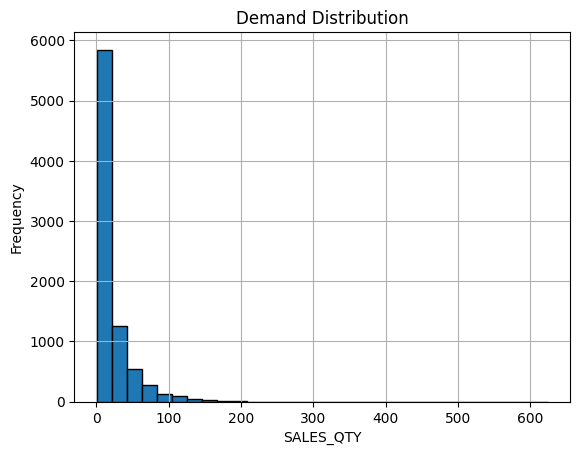

In [13]:
#plot the arrays

plt.hist(df['SALES_QTY'], bins=30, edgecolor='black')
plt.title('Demand Distribution')
plt.xlabel('SALES_QTY')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

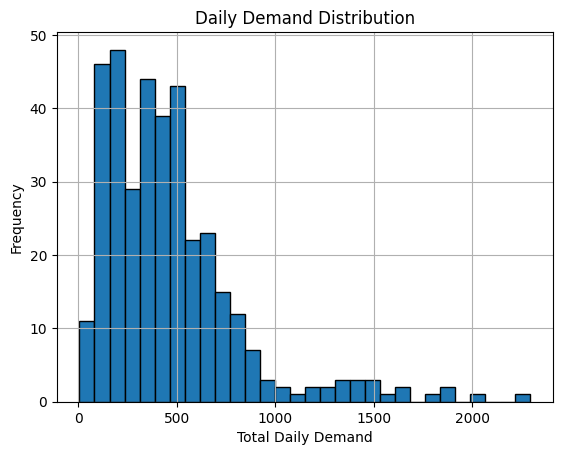

In [14]:
daily_demand = df.groupby('DATE')['SALES_QTY'].sum()
plt.hist(daily_demand, bins=30, edgecolor='black')
plt.title('Daily Demand Distribution')
plt.xlabel('Total Daily Demand')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
# Extract Time-based features
df = df.copy()

# Convert DATE to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)

df["Year"] = df["DATE"].dt.year
df["Month"] = df["DATE"].dt.month
df["Day"] = df["DATE"].dt.day
df["Dayofweek"] = df["DATE"].dt.dayofweek  # Monday=0, Sunday=6
df["Weekofyear"] = df["DATE"].dt.isocalendar().week
df["Dayofyear"] = df["DATE"].dt.dayofyear
df["Is_weekend"] = df["DATE"].dt.dayofweek >= 5

df.head()

,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Next_Purchase_Volume,Year,Month,Day,Dayofweek,Weekofyear,Dayofyear,Is_weekend
7,2024-01-03,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,8,20,10.0,2024,1,3,2,1,3,False
55,2024-01-05,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,10,25,9.0,2024,1,5,4,1,5,False
122,2024-01-09,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,9,24,4.0,2024,1,9,1,2,9,False
146,2024-01-10,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,4,10,2.0,2024,1,10,2,2,10,False
188,2024-01-12,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,2,5,9.0,2024,1,12,4,2,12,False


Create lag and frequency features

In [17]:
# Sort Data for Time-Series Consistency
df = df.sort_values(by=["PRODUCT_ID", "DATE"]).reset_index(drop=True)

# Create Lag Features (e.g., previous sales volume)
lags = [1, 2, 3, 7, 14, 30, 60]     # Define lags

# Create lag features for SALES_QTY
for lag in lags: 
    df[f'lag_qty_{lag}'] = df.groupby('PRODUCT_ID')['SALES_QTY'].shift(lag)
# Create lag features for SALES_VALUE
for lag in lags:
    df[f'lag_value_{lag}'] = df.groupby('PRODUCT_ID')['SALES_VALUE'].shift(lag)


# Create Rolling Statistics (Moving Averages, Std)
windows = [3, 7, 14]    # Define rolling windows

for window in windows:
    df[f"rolling_mean_{window}"] = df.groupby("PRODUCT_ID")["SALES_QTY"].shift(1).rolling(window).mean()
    df[f"rolling_std_{window}"] = df.groupby("PRODUCT_ID")["SALES_QTY"].shift(1).rolling(window).std()


# Frequency Features (How often a product is sold)
# Count purchases per product
df["Product_Sale_Count"] = df.groupby("PRODUCT_ID").cumcount() + 1

# Days since last sale
df["Days_Since_Last_Sale"] = df.groupby("PRODUCT_ID")["DATE"].diff().dt.days

# Average days between sales
df["Avg_Days_Between_Sales"] = df.groupby("PRODUCT_ID")["Days_Since_Last_Sale"].transform(lambda x: x.rolling(5, min_periods=1).mean())


# Encode Seasonal Cycles
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

df["Dayofweek_sin"] = np.sin(2 * np.pi * df["Dayofweek"] / 7)
df["Dayofweek_cos"] = np.cos(2 * np.pi * df["Dayofweek"] / 7)

print(df.shape)
df.head()

(8246, 42)


,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Next_Purchase_Volume,Year,Month,...,rolling_std_7,rolling_mean_14,rolling_std_14,Product_Sale_Count,Days_Since_Last_Sale,Avg_Days_Between_Sales,Month_sin,Month_cos,Dayofweek_sin,Dayofweek_cos
0,2024-01-03,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,8,20,10.0,2024,1,...,NaN,NaN,NaN,1,NaN,NaN,0.5,0.866025,0.974928,-0.222521
1,2024-01-05,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,10,25,9.0,2024,1,...,NaN,NaN,NaN,2,2.0,2.000000,0.5,0.866025,-0.433884,-0.900969
2,2024-01-09,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,9,24,4.0,2024,1,...,NaN,NaN,NaN,3,4.0,3.000000,0.5,0.866025,0.781831,0.623490
3,2024-01-10,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,4,10,2.0,2024,1,...,NaN,NaN,NaN,4,1.0,2.333333,0.5,0.866025,0.974928,-0.222521
4,2024-01-12,ANCHOR BLUE MILK_1000 ML,ANCHOR BLUE MILK,1000 ML,3.0,2,5,9.0,2024,1,...,NaN,NaN,NaN,5,2.0,2.250000,0.5,0.866025,-0.433884,-0.900969


In [18]:
# drop rows with NaNs due to shifting/rolling
df = df.dropna().reset_index(drop=True)
print(df.shape)

# # fill NaNs due to shifting/rolling with 0s
# df = df.fillna(0).reset_index(drop=True)
# print(df.shape)

(5784, 42)


## Preprocessing

In [19]:
# Convert Date to numeric Unix timestamp (to seconds)
df["DATE"] = df["DATE"].astype('int64') // 10**9            # or .astype('int64') if older pandas version

In [20]:
# Encode categorical features to numeric using Label Encoding

from sklearn.preprocessing import LabelEncoder

cols_to_encode = ['PRODUCT_BRAND', 'PACK_SIZE', 'PRODUCT_ID', 'Is_weekend']
encoders = {}
for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


df.head()

,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Next_Purchase_Volume,Year,Month,...,rolling_std_7,rolling_mean_14,rolling_std_14,Product_Sale_Count,Days_Since_Last_Sale,Avg_Days_Between_Sales,Month_sin,Month_cos,Dayofweek_sin,Dayofweek_cos
0,1715212800,0,0,1,3.0,8,23,6.0,2024,5,...,2.035401,5.214286,3.262339,61,1.0,1.0,0.5,-0.866025,0.433884,-0.900969
1,1715299200,0,0,1,3.0,6,15,8.0,2024,5,...,2.299068,5.500000,3.322418,62,1.0,1.0,0.5,-0.866025,-0.433884,-0.900969
2,1715472000,0,0,1,3.0,8,23,8.0,2024,5,...,1.676163,5.785714,3.166618,63,2.0,1.2,0.5,-0.866025,-0.781831,0.623490
3,1715644800,0,0,1,3.0,8,23,8.0,2024,5,...,1.718249,5.357143,2.239751,64,2.0,1.4,0.5,-0.866025,0.781831,0.623490
4,1715731200,0,0,1,3.0,8,23,2.0,2024,5,...,1.632993,5.714286,2.233609,65,1.0,1.4,0.5,-0.866025,0.974928,-0.222521


In [ ]:
y=df['Next_Purchase_Volume']
x=df.drop(columns=['Next_Purchase_Volume'], axis=1)

print(x.shape, y.shape)


(5784, 41) (5784,)


In [24]:
# Train-Test split - 80-20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

(4627, 41) (1157, 41)


In [38]:
# Merge x_test and y_test into one DataFrame
x_new = x_test.copy()
x_new['Next_Purchase_Volume'] = y_test.values 
x_new.shape

(1157, 42)

In [ ]:
## Saving x_val for evaluation later

path = '/data/x_test.csv'
x_new.to_csv(path, index=False)

## Training

In [26]:
# Define and train the Regression Model

model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.001,
    max_depth=3,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    gamma=0.1,
    reg_alpha=12.0,
    reg_lambda=12.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# model.fit(
#     x_train, y_train,
#     eval_set=[(x_val, y_val)],
#     early_stopping_rounds=50,
#     verbose=False
# )

model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.001, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=-1, num_parallel_tree=None, ...)

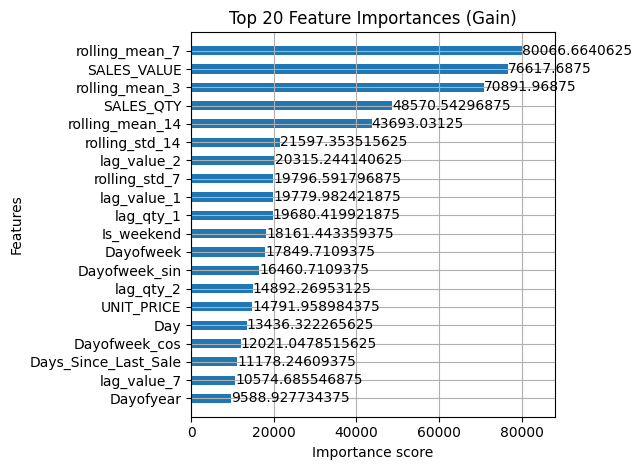

In [27]:
# Plot feature importance
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title('Top 20 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

In [29]:
## Evaluate training performance
# Make predictions on training set
y_train_pred = model.predict(x_train)

# Compute RMSE and R² on training set
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)


print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training R² Score: {train_r2:.4f}")

Training RMSE: 20.8894
Training MAE: 12.3824
Training R² Score: 0.4385


In [30]:
## Evaluate training performance

# Make predictions on test set
y_pred = model.predict(x_test)

# Evaluate the model
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)

print(f"Testing RMSE:   {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")

Testing RMSE:   21.2712
Testing MAE: 12.3824
Testing R² Score: 0.4243


In [31]:
# Inverse scale
# x_train_df = pd.DataFrame(scaler.inverse_transform(x_train), columns=x.columns)
x_train_df = x_train.copy()

# Convert float to int for encoded categorical columns before decoding
categorical_cols = list(encoders.keys())
for col in categorical_cols:
    x_train_df[col] = x_train_df[col].round().astype(int)  # Ensure proper label decoding
    x_train_df[col] = encoders[col].inverse_transform(x_train_df[col])        # Decode the labels using stored encoders
    
# Prepare y_train and y_train_pred for merge
y_train = y_train.reset_index(drop=True)
y_pred_series = pd.Series(y_train_pred, name='Predicted_Next_Purchase_Volume')

# Combine into one DataFrame
merged_df = pd.concat([x_train_df.reset_index(drop=True), y_train, y_pred_series], axis=1)
# merged_df.rename(columns={'Next_Purchase_Volume': 'y_true'}, inplace=True)

merged_df["DATE"] = pd.to_datetime(merged_df["DATE"], unit='s')

merged_df.head()

,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Year,Month,Day,...,rolling_std_14,Product_Sale_Count,Days_Since_Last_Sale,Avg_Days_Between_Sales,Month_sin,Month_cos,Dayofweek_sin,Dayofweek_cos,Next_Purchase_Volume,Predicted_Next_Purchase_Volume
0,2024-12-01,ANCHOR BLUE MILK_2000 ML,ANCHOR BLUE MILK,2000 ML,5.5,10,65,2024,12,1,...,23.325221,293,1.0,1.0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,35.0,18.215448
1,2024-09-06,PEPSI_250 ML,PEPSI,250 ML,2.0,2,3,2024,9,6,...,4.602914,112,1.0,1.4,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,2.0,8.336055
2,2024-07-16,DOVE BODY WASH_1000 ML,DOVE BODY WASH,1000 ML,12.0,87,954,2024,7,16,...,32.813827,196,1.0,1.0,-5.000000e-01,-8.660254e-01,0.781831,0.623490,58.0,66.316650
3,2024-06-03,DOVE BODY WASH_1000 ML,DOVE BODY WASH,1000 ML,12.0,26,288,2024,6,3,...,28.846696,153,1.0,1.0,1.224647e-16,-1.000000e+00,0.000000,1.000000,88.0,55.727032
4,2024-03-22,DASANI WATER_300 ML,DASANI WATER,300 ML,2.0,9,19,2024,3,22,...,2.032700,70,1.0,1.0,1.000000e+00,6.123234e-17,-0.433884,-0.900969,10.0,13.273713


In [32]:
# Compute squared error and RMSE per row
merged_df['Model_RMSE'] = np.sqrt((merged_df['Next_Purchase_Volume'] - merged_df['Predicted_Next_Purchase_Volume']) ** 2)

merged_df.head()

,DATE,PRODUCT_ID,PRODUCT_BRAND,PACK_SIZE,UNIT_PRICE,SALES_QTY,SALES_VALUE,Year,Month,Day,...,Product_Sale_Count,Days_Since_Last_Sale,Avg_Days_Between_Sales,Month_sin,Month_cos,Dayofweek_sin,Dayofweek_cos,Next_Purchase_Volume,Predicted_Next_Purchase_Volume,Model_RMSE
0,2024-12-01,ANCHOR BLUE MILK_2000 ML,ANCHOR BLUE MILK,2000 ML,5.5,10,65,2024,12,1,...,293,1.0,1.0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,35.0,18.215448,16.784552
1,2024-09-06,PEPSI_250 ML,PEPSI,250 ML,2.0,2,3,2024,9,6,...,112,1.0,1.4,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,2.0,8.336055,6.336055
2,2024-07-16,DOVE BODY WASH_1000 ML,DOVE BODY WASH,1000 ML,12.0,87,954,2024,7,16,...,196,1.0,1.0,-5.000000e-01,-8.660254e-01,0.781831,0.623490,58.0,66.316650,8.316650
3,2024-06-03,DOVE BODY WASH_1000 ML,DOVE BODY WASH,1000 ML,12.0,26,288,2024,6,3,...,153,1.0,1.0,1.224647e-16,-1.000000e+00,0.000000,1.000000,88.0,55.727032,32.272968
4,2024-03-22,DASANI WATER_300 ML,DASANI WATER,300 ML,2.0,9,19,2024,3,22,...,70,1.0,1.0,1.000000e+00,6.123234e-17,-0.433884,-0.900969,10.0,13.273713,3.273713


In [35]:
print(merged_df.shape)

(4627, 44)


In [ ]:
# Save DataFrame to CSV
path = '/data/train_df.csv'
merged_df.to_csv(path, index=False)

In [ ]:
# Save the trained model to a file
import joblib

path = '/models/xgboost_model.pkl'
joblib.dump(model, path)